## Question 15 - PAWS Benchmark, Data Inspection + GLoVE
In this section, I investigate the PAWS dataset, compute Jaccard similarity between the sentences, and train a logistic regression classifier using pretrained GLoVE embeddings

In [1]:
from datasets import load_dataset
ds = load_dataset("paws","labeled_final")


Split: train, Total examples: 49401
Paraphrases: 21829 (44.1874%)
Not paraphrases: 27572 (55.8126%)

Split: validation, Total examples: 8000
Paraphrases: 3539 (44.2375%)
Not paraphrases: 4461 (55.7625%)

Split: test, Total examples: 8000
Paraphrases: 3536 (44.2000%)
Not paraphrases: 4464 (55.8000%)


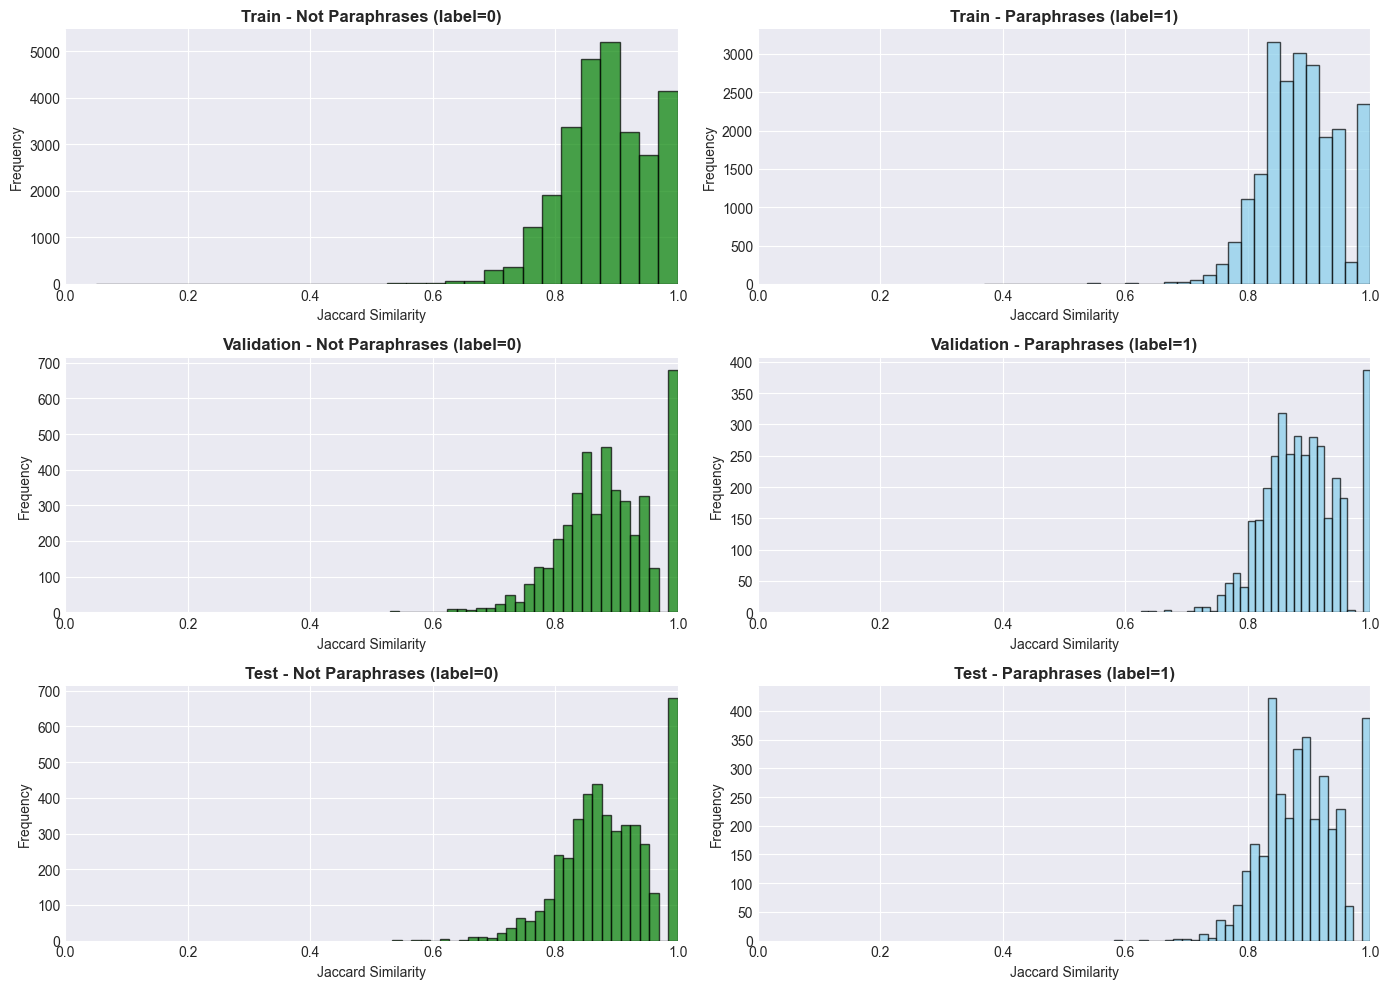

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")

def jaccard_similarity(example):
    tokens1 = set(example['sentence1'].lower().split())
    tokens2 = set(example['sentence2'].lower().split())
    
    #Compute intersection + Union
    intersection = tokens1.intersection(tokens2)
    union = tokens1.union(tokens2)
    
    if len(union) == 0:
        jaccard = 0.0
    else:
        jaccard=len(intersection) / len(union)
    return {'jaccard_similarity': jaccard}

train_data = ds['train'].map(jaccard_similarity)
validation_data = ds['validation'].map(jaccard_similarity)
test_data = ds['test'].map(jaccard_similarity)
datas = {"train": train_data, "validation" : validation_data, "test": test_data}

fig, axes = plt.subplots(3, 2, figsize=(14, 10))

for i, (split_name, split_data) in enumerate(datas.items()):
    n_examples = len(split_data)
    
    # Label distribution
    labels = split_data['label']
    n_paraphrase = sum(labels)
    n_not_paraphrase = len(labels) - n_paraphrase
    
    print(f"\nSplit: {split_name}, Total examples: {n_examples}")
    print(f"Paraphrases: {n_paraphrase} ({(n_paraphrase/n_examples)*100:.4f}%)")
    print(f"Not paraphrases: {n_not_paraphrase} ({(n_not_paraphrase/n_examples)*100:.4f}%)")
    
    #get jaccard
    jaccard_scores = np.array(split_data['jaccard_similarity'])
    labels_array = np.array(split_data['label'])
    jaccard_label_0 = jaccard_scores[labels_array == 0]
    jaccard_label_1 = jaccard_scores[labels_array == 1]
    
    # Histogram for label = 0 (Not paraphrases)
    axes[i, 0].hist(jaccard_label_0, bins=30, edgecolor='black', alpha=0.7, color='green')
    axes[i, 0].set_title(f'{split_name.capitalize()} - Not Paraphrases (label=0)', 
                         fontsize=12, fontweight='bold')
    axes[i, 0].set_xlabel('Jaccard Similarity')
    axes[i, 0].set_ylabel('Frequency')
    axes[i, 0].set_xlim(0, 1)
    
    # Histogram for label = 1 (Paraphrases)
    axes[i, 1].hist(jaccard_label_1, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    axes[i, 1].set_title(f'{split_name.capitalize()} - Paraphrases (label=1)', 
                         fontsize=12, fontweight='bold')
    axes[i, 1].set_xlabel('Jaccard Similarity')
    axes[i, 1].set_ylabel('Frequency')
    axes[i, 1].set_xlim(0, 1)

plt.tight_layout()
plt.show()

In [3]:
#get some examples
print("Dataset Examples")
print("\nExample of Paraphrase (label 0)")
for i, example in enumerate(train_data):
    if example['jaccard_similarity'] > 0.9 and example['label'] == 0:
        print(f"Sentence 1: {example['sentence1']}")
        print(f"Sentence 2: {example['sentence2']}")
        print(f"Jaccard: {example['jaccard_similarity']:.3f}")
        if i >= 0:
            break

print("\nExample of Not Paraphrase (label 1)")
for i, example in enumerate(train_data):
    if example['jaccard_similarity'] > 0.9 and example['label'] == 1:
        print(f"Sentence 1: {example['sentence1']}")
        print(f"Sentence 2: {example['sentence2']}")
        print(f"Jaccard: {example['jaccard_similarity']:.3f}")
        if i >= 0:
            break

Dataset Examples

Example of Paraphrase (label 0)
Sentence 1: There are also specific discussions , public profile debates and project discussions .
Sentence 2: There are also public discussions , profile specific discussions , and project discussions .
Jaccard: 0.917

Example of Not Paraphrase (label 1)
Sentence 1: The NBA season of 1975 -- 76 was the 30th season of the National Basketball Association .
Sentence 2: The 1975 -- 76 season of the National Basketball Association was the 30th season of the NBA .
Jaccard: 1.000


### Analysis
For all splits we can see Jaccard similarity is very high. Centered around 0.9. This means that many of the words present in sentence 1 are also present in sentence 2. So, if we use a bag of words model, it will be very hard to use this model to classify. Note that the PAWS dataset contains many sentence pairs that share almost identical words but differ in meaning due to word order changes as well as sentences with same words and same meanings. We need a model that uses word context to classify, not just whether words are present in both sentences.

### Using GloVE Embeddings and Classifying using Logistic Regression

In [4]:
embeddings_dict = {}
dimension_of_glove = 300
with open("glove/glove.6B.300d.txt", 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [5]:
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag, word_tokenize
import nltk

nltk.download('stopwords')
def get_wordnet_pos(tag):
    # Converts Penn Treebank tags to WordNet.
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

class GloVeEmbedder:
    def __init__(self, embeddings_dict):
        self.embeddings_dict = embeddings_dict
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        self.embedding_dim = len(next(iter(embeddings_dict.values())))
        
    def preprocess(self, text):
        #tokenize, lemmtize, filter out nonalphanumeric
        tokens = word_tokenize(text.lower())
        pos_tags = pos_tag(tokens)
        #lemmatize
        lemmatized = [
            self.lemmatizer.lemmatize(token, get_wordnet_pos(tag)) 
            for token, tag in pos_tags
        ]
        
        #remove stopwords, non-alphabetic, single characters
        filtered = [
            word for word in lemmatized 
            if word.isalpha() and 
               len(word) > 1 and 
               (word not in self.stop_words)
        ]
        
        return filtered
    
    def embed_doc(self, text):
        #Convert a document to embedding vector
        tokens = self.preprocess(text)
        word_vectors = []
        oov_count = 0
        
        for token in tokens:
            if token in self.embeddings_dict:
                vec = self.embeddings_dict[token]
                word_vectors.append(vec)
            else:
                oov_count += 1
        
        # if no valid words
        if len(word_vectors) == 0:
            print(f"WARNING: Document with no valid words. Sample tokens: {tokens[:5]}")
            return np.zeros(self.embedding_dim), 1.0
        
        #get word vectors and normalize + avg
        word_vectors = np.array(word_vectors)
        word_vectors = normalize(word_vectors, axis=1, norm='l2')
        doc_embedding = np.mean(word_vectors, axis=0)
        
        #find OOV rate
        total_tokens = len(tokens)
        oov_rate = oov_count / total_tokens if total_tokens > 0 else 0
        return doc_embedding, oov_rate
    
    def transform(self, documents):
        #Transform list of documents to embedding matrix
        embeddings = []
        oov_rates = []
        
        for i, doc in enumerate(documents):
            emb, oov = self.embed_doc(doc)
            embeddings.append(emb)
            oov_rates.append(oov)
        return np.array(embeddings), np.array(oov_rates)

def construct_features(embed1, embed2):
    u = embed1
    v = embed2
    uv_abs = np.abs(u-v)
    uv_product = u * v
    return np.concatenate([u,v,uv_abs,uv_product], axis = 1)
    
print("Creating doc embedder...")
embedder = GloVeEmbedder(
    embeddings_dict=embeddings_dict,
)

train_data = ds['train'].map(jaccard_similarity)
validation_data = ds['validation'].map(jaccard_similarity)
test_data = ds['test'].map(jaccard_similarity)

#transform train test valid
print("Transforming training documents...")
train_sent1_glove_emb, train_oov_rates = embedder.transform(train_data["sentence1"])
train_sent2_glove_emb, train_oov_rates = embedder.transform(train_data["sentence2"])

print("Transforming validation documents...")
valid_sent1_glove_emb, train_oov_rates = embedder.transform(validation_data["sentence1"])
valid_sent2_glove_emb, train_oov_rates = embedder.transform(validation_data["sentence2"])

print("Transforming test documents...")
test_sent1_glove_emb, train_oov_rates = embedder.transform(test_data["sentence1"])
test_sent2_glove_emb, train_oov_rates = embedder.transform(test_data["sentence2"])

print("Constructing pair features for training...")
glove_X_train = construct_features(train_sent1_glove_emb, train_sent2_glove_emb)
y_train = np.array(train_data['label'])

print("Constructing pair features for validation...")
glove_X_valid = construct_features(valid_sent1_glove_emb, valid_sent2_glove_emb)
y_valid = np.array(validation_data['label'])

print("Constructing pair features for test...")
glove_X_test = construct_features(test_sent1_glove_emb, test_sent2_glove_emb)
y_test = np.array(test_data['label'])

print(f"Feature shape: {glove_X_train.shape}")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jilli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Creating doc embedder...
Transforming training documents...
Transforming validation documents...
Transforming test documents...
Constructing pair features for training...
Constructing pair features for validation...
Constructing pair features for test...
Feature shape: (49401, 1200)


For the GloVe baseline, I chose Logistic Regression with L2 regularization and investigated a choice of C. This choice is justified by the nature of our feature construction: all 1,200 dimensions are derived from meaningful GloVe word embeddings through concatenation operations. Unlike sparse bag-of-words features where many dimensions may be irrelevant, these features are all informative. L2 regularization is more appropriate than L1 in this setting because it shrinks coefficients without eliminating features entirely, allowing the model to leverage information from all dimensions. I investigate several choices of C and report the best models test accuracy and f1.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, roc_curve, auc)
import time
import numpy as np

best_c = 0.1
best_acc = 0
best_model = None
for c in [0.01, 0.1, 1.0, 10.0]:
    print(f"\nTesting C: {c}")
    model = LogisticRegression(
        penalty='l2',
        C=c,
        solver='lbfgs',
        max_iter=1000,
        random_state=42
    )
    model.fit(glove_X_train, y_train)
    # Evaluate on validation set
    y_val_pred = model.predict(glove_X_valid)
    val_acc = accuracy_score(y_valid, y_val_pred)
    val_f1 = f1_score(y_valid, y_val_pred)
    cm = confusion_matrix(y_valid, y_val_pred)
    print(f"Accuracy:  {val_acc:.4f}")
    print(f"F1 Score:  {val_f1:.4f}")
    print(f"\nConfusion Matrix:")
    print(cm)
    if val_acc > best_acc:
        best_c = c
        best_acc = val_acc
        best_model = model

print("Training the best model...")
    #train best model
final_glove_model = LogisticRegression(
    penalty='l2',
    C=best_c,
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)
best_glove_model = final_glove_model.fit(glove_X_train, y_train)
start_time = time.time()
y_pred = final_glove_model.predict(glove_X_test)
end_time = time.time()
glove_model_time = end_time - start_time
# Evaluate of best model on test set
test_acc = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(f"\nBest Model C:  {best_c}")
print(f"Inference time (1000 pairs): {(glove_model_time / len(glove_X_test)) * 1000:.4f} seconds")
print(f"Best Model Accuracy:  {test_acc:.4f}")
print(f"Best Model F1 Score:  {test_f1:.4f}")
print(f"Best Model Confusion Matrix:")
print(cm)
print("\n")

glove_encoder_results = {
    'test_accuracy': test_acc,
    'test_f1': test_f1,
    'confusion_matrix': cm,
    'inference_time_per_1000': (glove_model_time / len(glove_X_test)) * 1000
}


Testing C: 0.01
Accuracy:  0.5576
F1 Score:  0.0000

Confusion Matrix:
[[4461    0]
 [3539    0]]

Testing C: 0.1
Accuracy:  0.5571
F1 Score:  0.1096

Confusion Matrix:
[[4239  222]
 [3321  218]]

Testing C: 1.0
Accuracy:  0.5615
F1 Score:  0.2002

Confusion Matrix:
[[4053  408]
 [3100  439]]

Testing C: 10.0
Accuracy:  0.5596
F1 Score:  0.2506

Confusion Matrix:
[[3888  573]
 [2950  589]]
Training the best model...

Best Model C:  1.0
Inference time (1000 pairs): 0.0051 seconds
Best Model Accuracy:  0.5526
Best Model F1 Score:  0.2174
Best Model Confusion Matrix:
[[3924  540]
 [3039  497]]




This results in a poor F1 score of 0.13 for the best model. Note that based on the confusion matrix, we can tell that the model is almost always predicting "not paraphrase" (class 0). Since GloVE is context-blind, it is not expected to do well on this dataset. I will investigate other methods in the next parts.

## Question 16 - Transformer Approaches on PAWS: Bi-encoder vs Cross-encoder
In this section, I investigate using transformers on PAWS. I use two methods of encoding, bi-encoding and cross-encoding, and evaluate their performance

### Using the Bi-encoder

In [7]:
from sentence_transformers import SentenceTransformer
import torch
from tqdm import tqdm

MODEL_NAME = "all-MiniLM-L6-v2"

print("Loading model...")
device = "cuda" if torch.cuda.is_available() else "cpu"
bi_encoder_model = SentenceTransformer(MODEL_NAME, device=device)
print(f"Model loaded on this device: {device}")

def bi_encoder(sent1, sent2, batch_size=32):
#utilize sentence-transformers library to encode texts (truncation method used automatically)
    bi_encoder_model.max_seq_length = 512  # Set truncation max_se_length to 512
    print(f"Encoding {len(sent1)} documents...")
    embeddings_sent1 = bi_encoder_model.encode(
        sent1,
        batch_size=batch_size,
        show_progress_bar=True,
        convert_to_numpy=True
    )
    embeddings_sent2 = bi_encoder_model.encode(
        sent2,
        batch_size=batch_size,
        show_progress_bar=True,
        convert_to_numpy=True
    )
    embeddings = construct_features(embeddings_sent1, embeddings_sent2)
    return torch.from_numpy(embeddings)

#transform train test valid
print("Transforming training documents...")
train_llm_emb = bi_encoder(train_data["sentence1"], train_data["sentence2"])
print("Transforming validation documents...")
validation_llm_emb = bi_encoder(validation_data["sentence1"], validation_data["sentence2"])
print("Transforming test documents...")
test_llm_emb = bi_encoder(test_data["sentence1"], test_data["sentence2"])
print(f"\nTransformer Train shape: {train_llm_emb.shape}")
print(f"Transformer Test shape: {train_llm_emb.shape}")
print(f"Embedding dimension: {train_llm_emb.shape[1]}")

Loading model...
Model loaded on this device: cuda
Transforming training documents...
Encoding 49401 documents...


Batches:   0%|          | 0/1544 [00:00<?, ?it/s]

Batches:   0%|          | 0/1544 [00:00<?, ?it/s]

Transforming validation documents...
Encoding 8000 documents...


Batches:   0%|          | 0/250 [00:00<?, ?it/s]

Batches:   0%|          | 0/250 [00:00<?, ?it/s]

Transforming test documents...
Encoding 8000 documents...


Batches:   0%|          | 0/250 [00:00<?, ?it/s]

Batches:   0%|          | 0/250 [00:00<?, ?it/s]


Transformer Train shape: torch.Size([49401, 1536])
Transformer Test shape: torch.Size([49401, 1536])
Embedding dimension: 1536


In [8]:
# Prepare data
X_train = train_llm_emb
y_train = np.array(train_data["label"])

X_val = validation_llm_emb
y_val = np.array(validation_data["label"])

X_test = test_llm_emb
y_test = np.array(test_data["label"])

#Hyperparameter tuning on validation set
print("Tune hyperparameters on validation set")
best_c = 0.1
best_val_acc = 0
best_model = None

Tune hyperparameters on validation set


In [9]:


C_values = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

for c in C_values:
    print(f"\nTesting C: {c}")
    lr_model = LogisticRegression(
        penalty='l2',
        C=c,
        solver='lbfgs',
        max_iter=1000,
        random_state=42
    )
    lr_model.fit(X_train, y_train)
    
    # Evaluate on validation set
    y_val_pred = lr_model.predict(X_val)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred)
    
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Validation F1 Score: {val_f1:.4f}")
    
    # Track best model based on validation accuracy
    if val_acc > best_val_acc:
        best_c = c
        best_val_acc = val_acc
        best_model = lr_model

print(f"\nBest Model: C = {best_c}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")

# Final evaluation on test set with best model
print("Final eval on test set")

start_time = time.time()
y_test_pred = best_model.predict(X_test)
end_time = time.time()
inference_time = end_time - start_time

test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
cm = confusion_matrix(y_test, y_test_pred)

print(f"Best C value: {best_c}")
print(f"Inference time (1000 pairs): {(inference_time / len(X_test)) * 1000:.4f} seconds")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"\nConfusion Matrix:")
print(cm)

bi_encoder_results = {
    'test_accuracy': test_acc,
    'test_f1': test_f1,
    'confusion_matrix': cm,
    'inference_time_per_1000': (inference_time / len(X_test)) * 1000
}

final_bi_enc_model = best_model


Testing C: 0.001
Validation Accuracy: 0.5576
Validation F1 Score: 0.0000

Testing C: 0.01
Validation Accuracy: 0.5984
Validation F1 Score: 0.3366

Testing C: 0.1
Validation Accuracy: 0.6071
Validation F1 Score: 0.4820

Testing C: 1.0
Validation Accuracy: 0.6218
Validation F1 Score: 0.5232

Testing C: 10.0
Validation Accuracy: 0.6214
Validation F1 Score: 0.5431

Testing C: 100.0
Validation Accuracy: 0.6109
Validation F1 Score: 0.5393

Best Model: C = 1.0
Best Validation Accuracy: 0.6218
Final eval on test set
Best C value: 1.0
Inference time (1000 pairs): 0.0065 seconds
Test Accuracy: 0.6180
Test F1 Score: 0.5268

Confusion Matrix:
[[3243 1221]
 [1835 1701]]


### Interpretation
We can see that Bi-encoder performs much better than GloVe. This is because, GloVe assigns a single fixed vector to each word regardless of context. The word "run" gets the same embedding whether it means "run a 5k" or "run for president". When you get GloVe vectors for a sentence, you're getting static, context-free representations. Meanwhile, the bi-encoder uses self-attention to create contextual embeddings. Each token's representation depends on all other tokens in the sentence, resulting in the same word getting different representations depending on the surrounding words. Therefore, the bi-encoder has contextual understanding that gives it the advantage here. 

Additionally the pre-training for each method plays a role here. GLoVE was trained on co-occurence stats from a specific text corpus (about 6B tokens). Meanwhile the bi-encoder leverages an LLM that was pretrained on a MASSIVE corpus (100B+ tokens). Also LLMs are often pretrained for specific objectgives including next sentence prediciton and sentence pair classification so the model already has some idea of what can make sentences seem "similar". 

### Using the Cross-Encoder

In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import torch

model_name = "distilbert-base-uncased"
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(model_name)
cross_encoder_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
).to(device)
print(f"Model loaded on: {device}")

def prepare_dataset(data, tokenizer, max_length=512):
    def tokenize_function(examples):
        return tokenizer(
            examples["sentence1"],
            examples["sentence2"],
            truncation=True,
            padding="max_length", 
            max_length=max_length,
        )
    columns_to_remove = [col for col in data.column_names if col != 'label']
    # Apply tokenization
    tokenized_dataset = data.map(
        tokenize_function,
        batched=True,
        remove_columns=columns_to_remove 
    )

    if 'label' in tokenized_dataset.column_names:
        tokenized_dataset = tokenized_dataset.rename_column('label', 'labels')
    return tokenized_dataset

print("Preparing training dataset...")
cross_train_dataset = prepare_dataset(train_data, tokenizer)
print("Preparing validation dataset...")
cross_val_dataset = prepare_dataset(validation_data, tokenizer)
print("Preparing testing dataset...")
cross_test_dataset = prepare_dataset(test_data, tokenizer)

print(f"\nDataset sizes:")
print(f"Train: {len(cross_train_dataset)}")
print(f"Validation: {len(cross_val_dataset)}")
print(f"Test: {len(cross_test_dataset)}")

# what columns does this give us?
print(f"\nTrain dataset columns: {cross_train_dataset.column_names}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded on: cuda
Preparing training dataset...
Preparing validation dataset...
Preparing testing dataset...

Dataset sizes:
Train: 49401
Validation: 8000
Test: 8000

Train dataset columns: ['labels', 'input_ids', 'attention_mask']


In [11]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import json
import os

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    
    return {
        'accuracy': acc,
        'f1': f1
    }

SAVED_MODEL_DIR = "./saved_cross_encoder_best_model"
FORCE_RETRAIN = False  # Set to True to force retraining

# Check if we have a saved model
if os.path.exists(SAVED_MODEL_DIR) and not FORCE_RETRAIN:
    print("!!!LOADING PREVIOUSLY TRAINED MODEL")
    print(f"Found saved model at: {SAVED_MODEL_DIR}")
    print("skipping training...")
    best_model = AutoModelForSequenceClassification.from_pretrained(SAVED_MODEL_DIR).to(device)
    
    # Load the saved results
    import json
    with open(os.path.join(SAVED_MODEL_DIR, "cross_enc_training_results.json"), "r") as f:
        saved_results = json.load(f)
    
    best_lr = saved_results['best_lr']
    best_val_acc = saved_results['best_val_acc']
    
    print(f"Best learning rate: {best_lr}")
    print(f"Best validation accuracy: {best_val_acc:.4f}")

else:
    print("!!!NO SAVED MODEL FOUND. TRAINING FROM SCRATCH")
    
    # Hyperparameter tuning
    learning_rates = [5e-5, 2e-5]
    best_val_acc = 0
    best_lr = None
    best_model = None
    best_trainer = None
    
    print("Tuning the cross-encoders hyperparameters")
    for lr in learning_rates:
        print(f"Training with Learning Rate: {lr}")
        
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=2
        ).to(device)
        
        # Verify model is on GPU
        print(f"Model device: {next(model.parameters()).device}")
        
        #training args
        training_args = TrainingArguments(
            output_dir=f"./cross_encoder_results_lr_{lr}",
            num_train_epochs=2,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=32,
            learning_rate=lr,
            eval_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="accuracy",
            seed=42,
            no_cuda=False,
        )
        
        #trainer
        trainer = Trainer(
            model=cross_encoder_model,
            args=training_args,
            train_dataset=cross_train_dataset,
            eval_dataset=cross_val_dataset,
            compute_metrics=compute_metrics,
        )
        
        # Train
        print("Starting training...")
        trainer.train()
        
        # Eval
        print("\nEvaluating on validation set...")
        val_results = trainer.evaluate()
        val_acc = val_results['eval_accuracy']
        val_f1 = val_results['eval_f1']
        
        print(f"\nValidation Results:")
        print(f"  Accuracy: {val_acc:.4f}")
        print(f"  F1 Score: {val_f1:.4f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_lr = lr
            best_model = trainer.model
            best_trainer = trainer
    
    print(f"Fount the best model.")
    print(f"Best Learning Rate: {best_lr}")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    
    #save best model
    print("Saving best model for future use...")
    best_model.save_pretrained(SAVED_MODEL_DIR)
    tokenizer.save_pretrained(SAVED_MODEL_DIR)  # Save tokenizer too
    
    #save training
    training_results = {
        'best_lr': best_lr,
        'best_val_acc': best_val_acc,
    }
    with open(os.path.join(SAVED_MODEL_DIR, "cross_enc_training_results.json"), "w") as f:
        json.dump(training_results, f, indent=2)
    print(f"Model saved to: {SAVED_MODEL_DIR}")
    
print("Final evaluation on the test set with best model...")

#best model on GPU
best_model = best_model.to(device)
print(f"Best model device: {next(best_model.parameters()).device}")

final_trainer = Trainer(
    model=best_model,
    args=TrainingArguments(
        output_dir="./cross_encoder_final_results",
        per_device_eval_batch_size=32,
        no_cuda=False,
    ),
    compute_metrics=compute_metrics,
)

# Get predictions and time it :)
start_time = time.time()
predictions = final_trainer.predict(cross_test_dataset)
end_time = time.time()
inference_time = end_time - start_time

y_pred = np.argmax(predictions.predictions, axis=-1)
y_test = np.array(cross_test_dataset['labels'])

# Metrics
test_acc = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

#results
print(f"Final Test Results")
print(f"Best learning rate: {best_lr}")
print(f"Total inference time: {inference_time:.2f} seconds")
print(f"Inference time per 1000 pairs: {(inference_time / len(cross_test_dataset)) * 1000:.4f} seconds")
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"\nConfusion Matrix:")
print(cm)

# Save results for comparison in part (d)
cross_encoder_results = {
    'best_lr': best_lr,
    'test_accuracy': test_acc,
    'test_f1': test_f1,
    'confusion_matrix': cm,
    'inference_time_per_1000': (inference_time / len(cross_test_dataset)) * 1000
}

final_cross_encoder_model = best_model
final_cross_encoder_trainer = final_trainer

!!!LOADING PREVIOUSLY TRAINED MODEL
Found saved model at: ./saved_cross_encoder_best_model
skipping training...
Best learning rate: 2e-05
Best validation accuracy: 0.8824
Final evaluation on the test set with best model...
Best model device: cuda:0


Final Test Results
Best learning rate: 2e-05
Total inference time: 51.96 seconds
Inference time per 1000 pairs: 6.4946 seconds

Test Accuracy: 0.8759
Test F1 Score: 0.8645

Confusion Matrix:
[[3838  626]
 [ 367 3169]]


In [12]:
# Analyze results
print(f"{'Encoder':<16} {'Test Accuracy':<16} {'Test F1':<12} {'Inference Time (per 1k pairs)':<12}")
print("-" * 75)
print(f"{'GLoVe':<16} {glove_encoder_results['test_accuracy']:<16.4f} {glove_encoder_results['test_f1']:<12.4f} {glove_encoder_results['inference_time_per_1000']:<12.4f}")
print(f"{'Bi-encoder':<16} {bi_encoder_results['test_accuracy']:<16.4f} {bi_encoder_results['test_f1']:<12.4f} {bi_encoder_results['inference_time_per_1000']:<12.4f}")
print(f"{'Cross-encoder':<16} {cross_encoder_results['test_accuracy']:<16.4f} {cross_encoder_results['test_f1']:<12.4f} {cross_encoder_results['inference_time_per_1000']:<12.4f}")

Encoder          Test Accuracy    Test F1      Inference Time (per 1k pairs)
---------------------------------------------------------------------------
GLoVe            0.5526           0.2174       0.0051      
Bi-encoder       0.6180           0.5268       0.0065      
Cross-encoder    0.8759           0.8645       6.4946      


### Analysis
As you can see GLoVE performs the worst (F1 = 0.21), Bi-encoder is next (F1 = 0.52), and Cross-encoder performs best (F1 = 0.86). Note that while cross-encoder performs signifigantly better than the Bi-encoder, it also has a longer inference time of ~6.6 seconds per 1000 pairs. The cross-encoder performs best because the sentences are fed into the encoder together. Self attention operates across both sentences simulaneously, allowing the model to compare specific phrases between the two sentences. Additionally, the model is fine-tuned end-to-end on PAWS training data with the actual paraphrase classification objective, which helps its performance signifigantly.

## Question 17 - Prompt-based Paraphrase Classification with Qwen

Below I construct a Qwen/Qwen2.5-3B-Instruct model with decoding parameters:
- max_new_tokens=32 - Maximum length of generated response
- num_beams=1 - No beam search (greedy decoding)
- do_sample=False - Deterministic generation (no sampling)

I perform both zero-shot and few-shot prompting and compare the outputs.

In [16]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import pandas as pd
from tqdm import tqdm

model_name = "Qwen/Qwen2.5-3B-Instruct"
MAX_NEW_TOKENS = 32

# Check GPU availability
if torch.cuda.is_available():
    print("Will be using GPU!")
else:
    print("GPU is NOT available. Running on CPU (this will be slow).")
print()

print("Loading model...")
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left'

qwen_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    device_map="auto",
    trust_remote_code=True
)

print("Model loaded successfully!")
print()

def create_balanced_subset(dataset, n_samples=200):
    # Get equal samples from each class, combine and shuffle
    df = pd.DataFrame(dataset)
    n_per_class = n_samples // 2
    paraphrase_samples = df[df['label'] == 1].sample(n=n_per_class, random_state=42)
    not_paraphrase_samples = df[df['label'] == 0].sample(n=n_per_class, random_state=42)
    subset = pd.concat([paraphrase_samples, not_paraphrase_samples])
    subset = subset.sample(frac=1, random_state=42).reset_index(drop=True)
    return subset

def create_prompt(sentence1, sentence2, examples=None):
    if examples is None:
        prompt = f"""Decide if these sentences are paraphrases. Respond with only "paraphrase" or "not paraphrase".

Sentence 1: {sentence1}
Sentence 2: {sentence2}
Answer:"""
    else:
        prompt = "Decide if these sentences are paraphrases. Respond with only \"paraphrase\" or \"not paraphrase\".\n\n"
        
        for s1, s2, label in examples:
            label_text = label if isinstance(label, str) else ("paraphrase" if label == 1 else "not paraphrase")
            prompt += f"Sentence 1: {s1}\nSentence 2: {s2}\nAnswer: {label_text}\n\n"
        prompt += f"Sentence 1: {sentence1}\nSentence 2: {sentence2}\nAnswer:"
    
    return prompt
    
def paraphrase_checker(sentence_pairs, fewshot_examples=None, batch_size=8):
    #check if paraphrase in batches
    results = []
    total_batches = (len(sentence_pairs) + batch_size - 1) // batch_size
    
    for i in tqdm(range(0, len(sentence_pairs), batch_size), desc="Processing batches", total=total_batches):
        batch = sentence_pairs[i:i+batch_size]
        prompts = []
        
        for s1, s2 in batch:
            prompt = create_prompt(s1, s2, examples=fewshot_examples)
            all_messages = [{"role": "user", "content": prompt}]
            text = tokenizer.apply_chat_template(all_messages, tokenize=False, add_generation_prompt=True)
            prompts.append(text)
    
        
        input_for_model = tokenizer(
            prompts, 
            return_tensors="pt",
            padding=True, 
            truncation=True,
            max_length=2048
        ).to(qwen_model.device)
        
        with torch.no_grad():
            outputs = qwen_model.generate(
                **input_for_model,
                max_new_tokens=MAX_NEW_TOKENS,
                num_beams=1,
                do_sample=False,
                pad_token_id=tokenizer.pad_token_id
            )
        
        for j, output in enumerate(outputs):
            response = tokenizer.decode(output[input_for_model['input_ids'].shape[1]:], skip_special_tokens=True)
            results.append(response.strip())
    
    return results

def get_label(text):
    if "not paraphrase" in text.lower() or "not a paraphrase" in text.lower():
        return 0
    elif "paraphrase" in text.lower():
        return 1
    else:
        return 1

def get_fewshot_examples(train_data, n_examples=6):
    # Get examples from each class
    train_df = pd.DataFrame(train_data)
    n_per_class = n_examples // 2
    paraphrases = train_df[train_df['label'] == 1].sample(n=n_per_class, random_state=42)
    not_paraphrases = train_df[train_df['label'] == 0].sample(n=n_per_class, random_state=42)
    
    examples = []
    para_list = list(paraphrases.iterrows())
    not_para_list = list(not_paraphrases.iterrows())
    
    for i in range(n_per_class):
        # Add a paraphrase example
        _, row = para_list[i]
        examples.append((row['sentence1'], row['sentence2'], 'paraphrase'))
        
        # Add a not paraphrase example
        _, row = not_para_list[i]
        examples.append((row['sentence1'], row['sentence2'], 'not paraphrase'))
    
    return examples
        
print("Creating balanced 200-sample subset...")
test_subset = create_balanced_subset(test_data, n_samples=200)

print(f"\nFirst few examples:")
print(test_subset[['sentence1', 'sentence2', 'label']].head())

# Prepare sentence pairs for batch processing
sentence_pairs = list(zip(test_subset['sentence1'], test_subset['sentence2']))
true_labels = test_subset['label'].tolist()

print(f"\nPrepared {len(sentence_pairs)} sentence pairs for evaluation")
print()


# zero shot
print("Running zero shot inference...")
test_prompt = create_prompt(sentence_pairs[0][0], sentence_pairs[0][1])
print("\n")
print("SAMPLE ZERO-SHOT PROMPT:")
print(test_prompt)
print("\n")
start_zero = time.time()
out = paraphrase_checker(sentence_pairs, batch_size=8)
predictions = [get_label(output) for output in out]
end_zero = time.time()
zero_shot_time = end_zero - start_zero

# Calculate metrics
zero_shot_accuracy = accuracy_score(true_labels, predictions)
zero_shot_f1 = f1_score(true_labels, predictions)
zero_shot_cm = confusion_matrix(true_labels, predictions)

print(f"\nZero Shot Test Results")
print(f"Test Accuracy: {zero_shot_accuracy:.4f}")
print(f"Test F1 Score: {zero_shot_f1:.4f}")
print(f"\nConfusion Matrix:")
print(zero_shot_cm)
print()

# few shot
print("Running few shot inference...")
examples = get_fewshot_examples(train_data, 6)
test_prompt = create_prompt(sentence_pairs[0][0], sentence_pairs[0][1], examples)
print("\n")
print("SAMPLE FEW-SHOT PROMPT:")
print(test_prompt)
print("\n")
start_few = time.time()
out = paraphrase_checker(sentence_pairs, batch_size=8, fewshot_examples=examples)
end_few = time.time()
few_shot_time = end_few - start_few
predictions = [get_label(output) for output in out]

few_shot_accuracy = accuracy_score(true_labels, predictions)
few_shot_f1 = f1_score(true_labels, predictions)
few_shot_cm = confusion_matrix(true_labels, predictions)

print(f"\nFewShot Test Results")
print(f"Test Accuracy: {few_shot_accuracy:.4f}")
print(f"Test F1 Score: {few_shot_f1:.4f}")
print(f"\nConfusion Matrix:")
print(few_shot_cm)

Will be using GPU!

Loading model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


Model loaded successfully!

Creating balanced 200-sample subset...

First few examples:
                                           sentence1  \
0  The first formal description of the Vietnamese...   
1  The brewery produces eight standard beers and ...   
2  Bhavani , Ajay , & Hari lied to police that La...   
3  The next A4 segment will connect Štip ( A3 jun...   
4  Hamilton Ventura has won the South America Gam...   

                                           sentence2  label  
0  The first formal description of the Vietnamese...      1  
1  The brewery produces eight standard beers and ...      1  
2  Bhavani , Ajay and Hari lied to the police tha...      1  
3  The next A4 segment will connect Štip ( A3 jun...      0  
4  The Álvarez won the South America Games agains...      0  

Prepared 200 sentence pairs for evaluation

Running zero shot inference...


SAMPLE ZERO-SHOT PROMPT:
Decide if these sentences are paraphrases. Respond with only "paraphrase" or "not paraphrase".

Sent

Processing batches: 100%|██████████████████████████████████████████████████████████████| 25/25 [00:42<00:00,  1.68s/it]



Zero Shot Test Results
Test Accuracy: 0.8300
Test F1 Score: 0.8283

Confusion Matrix:
[[84 16]
 [18 82]]

Running few shot inference...


SAMPLE FEW-SHOT PROMPT:
Decide if these sentences are paraphrases. Respond with only "paraphrase" or "not paraphrase".

Sentence 1: William died in 1859 and Elizabeth died the following year .
Sentence 2: In 1859 , William and Elizabeth died the following year .
Answer: paraphrase

Sentence 1: St Francis Inter College , Aligarh Road , is one of the best and most renowned schools in Hathras .
Sentence 2: St Francis Inter College , Hathras Road , is one of the best and most renowned schools in Aligarh .
Answer: not paraphrase

Sentence 1: The leaves are generally 1.5-4 mm wide and 0.2-0.7 mm long .
Sentence 2: The leaves are typically 1.5-4 mm wide and 0.2-0.7 mm long .
Answer: paraphrase

Sentence 1: Swarthmore is represented at the General Assembly of Pennsylvania as the PA 161st Legislative District and the PA 26th Senate District .
Sentence 2: Swa

Processing batches: 100%|██████████████████████████████████████████████████████████████| 25/25 [00:59<00:00,  2.39s/it]


FewShot Test Results
Test Accuracy: 0.6800
Test F1 Score: 0.5362

Confusion Matrix:
[[99  1]
 [63 37]]


### On Zero-Shot Outperforming Few-Shot
The zero-shot approach achieved higher accuracy (0.83) compared to few-shot (0.68), which might be attributed to several factors. First, the PAWS dataset is specifically designed as an adversarial benchmark where sentence pairs often share high lexical similarity but differ in meaning due to subtle differences. The randomly sampled few-shot examples may have inadvertently introduced a conservative prediction bias. The confusion matrix shows the model predicted "not paraphrase" for 63 out of 100 true paraphrases. The few-shot examples contain cases where small differences (such as "Aligarh Road" vs "Hathras Road") indicated non-paraphrases, which might lead the model to over-generalize this pattern and reject paraphrases with any minor variation. In contrast, the zero-shot approach relied solely on the model's pre-trained understanding of paraphrasing, which appears to work better for the PAWS task.

In [18]:
test_200_subset = test_subset
true_labels_200 = test_200_subset['label'].tolist()

# Testing with GloVE on 200 samples
print("\n1. Evaluating GLoVe...")
sent1_glove_200, _ = embedder.transform(test_200_subset["sentence1"])
sent2_glove_200, _ = embedder.transform(test_200_subset["sentence2"])
glove_X_200 = construct_features(sent1_glove_200, sent2_glove_200)

start_time = time.time()
glove_pred_200 = best_glove_model.predict(glove_X_200)
glove_time_200 = time.time() - start_time

glove_acc_200 = accuracy_score(true_labels_200, glove_pred_200)
glove_f1_200 = f1_score(true_labels_200, glove_pred_200)
glove_cm_200 = confusion_matrix(true_labels_200, glove_pred_200)

print(f"Accuracy: {glove_acc_200:.4f}, F1: {glove_f1_200:.4f}, Time: {glove_time_200:.4f}s")

# Testing with bi-encoder on 200 samples
print("\n2. Evaluating Bi-encoder...")
bi_X_200 = bi_encoder(
    test_200_subset["sentence1"].tolist(), 
    test_200_subset["sentence2"].tolist(),
    batch_size=32
)

start_time = time.time()
bi_pred_200 = final_bi_enc_model.predict(bi_X_200)
bi_time_200 = time.time() - start_time

bi_acc_200 = accuracy_score(true_labels_200, bi_pred_200)
bi_f1_200 = f1_score(true_labels_200, bi_pred_200)
bi_cm_200 = confusion_matrix(true_labels_200, bi_pred_200)

print(f"Accuracy: {bi_acc_200:.4f}, F1: {bi_f1_200:.4f}, Time: {bi_time_200:.4f}s")

# Testing with cross-encoder on 200 samples
print("\n3. Evaluating Cross-encoder...")
from datasets import Dataset as HFDataset

# Create dataset for the 200 samples (same format as before)
cross_200_dict = {
    'sentence1': test_200_subset['sentence1'].tolist(),
    'sentence2': test_200_subset['sentence2'].tolist(),
    'labels': test_200_subset['label'].tolist()
}
cross_200_dataset = HFDataset.from_dict(cross_200_dict)

# Tokenize using the same prepare_dataset function from before
cross_tokenizer_200 = AutoTokenizer.from_pretrained(SAVED_MODEL_DIR)
cross_200_tokenized = prepare_dataset(cross_200_dataset, cross_tokenizer_200)

# Use the saved trainer to predict
start_time = time.time()
predictions_200 = final_cross_encoder_trainer.predict(cross_200_tokenized)
cross_time_200 = time.time() - start_time

cross_pred_200 = np.argmax(predictions_200.predictions, axis=-1)

cross_acc_200 = accuracy_score(true_labels_200, cross_pred_200)
cross_f1_200 = f1_score(true_labels_200, cross_pred_200)
cross_cm_200 = confusion_matrix(true_labels_200, cross_pred_200)

print(f"Accuracy: {cross_acc_200:.4f}, F1: {cross_f1_200:.4f}, Time: {cross_time_200:.4f}s")

print("\n")
print("COMPARING ALL MODELS ON 200 SAMPLES (BELOW)")
print("\n")

comparison_df = pd.DataFrame({
    'Model': ['GLoVe + LR', 'Bi-encoder + LR', 'Cross-encoder + LR', 'Qwen (0-shot)', 'Qwen (few-shot)'],
    'Accuracy': [glove_acc_200, bi_acc_200, cross_acc_200, zero_shot_accuracy, few_shot_accuracy],
    'F1 Score': [glove_f1_200, bi_f1_200, cross_f1_200, zero_shot_f1, few_shot_f1],
    'Time (s)': [glove_time_200, bi_time_200, cross_time_200, zero_shot_time, few_shot_time]
})

print(comparison_df.to_string(index=False))


1. Evaluating GLoVe...
Accuracy: 0.5050, F1: 0.2205, Time: 0.0015s

2. Evaluating Bi-encoder...
Encoding 200 documents...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Accuracy: 0.6000, F1: 0.5652, Time: 0.0020s

3. Evaluating Cross-encoder...


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Accuracy: 0.8850, F1: 0.8844, Time: 11.5390s


COMPARING ALL MODELS ON 200 SAMPLES (BELOW)


             Model  Accuracy  F1 Score  Time (s)
        GLoVe + LR     0.505  0.220472  0.001499
   Bi-encoder + LR     0.600  0.565217  0.002004
Cross-encoder + LR     0.885  0.884422 11.539000
     Qwen (0-shot)     0.830  0.828283 42.062804
   Qwen (few-shot)     0.680  0.536232 59.849457


## Evaluation of all models on PAWS:

Based on these results, Cross-encoder + LR had the best Accuracy / f1 score out of all models. It performed better than Qwen, likely because it had been fine-tuned on PAWS data, and it was able to learn how to solve this adversarial task of paraphrase detection. Additionally the cross-attention between the two sentences lets the model compare phrases between sentences which gives it an advantage over models like GloVE and Bi-encoder. Qwen zero-shot also performed well, likely because, as an LLM it would have been pre-trained on similar tasks. Unexpectedly, Qwen few-shot performed worse than Qwen zero-shot, probably because the few-shot examples that were provided led to the model becoming overly conservative (as discussed previously). Additionally Qwen few-shot had the longest inference time (perhaps due to the length of the prompt). As expected, Bi-encoder + LR and GloVE had the worst F1 and Accuracy scores but the shortest inference times.

In my opinion, Cross-encoder + LR, is the best model for this task. With an F1 and Accuracy scores at 0.88, it achieves good performance on the PAWS dataset. Additionally, its inference time of 11 seconds is suitable for this task. 
